In [1]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_excel('earthquake_Nepal_EDA.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1245 non-null   object        
 1   time            1245 non-null   object        
 2   latitude        1245 non-null   float64       
 3   longitude       1245 non-null   float64       
 4   magnitude       1245 non-null   float64       
 5   epicenter       1245 non-null   object        
 6   date_ad         1245 non-null   object        
 7   date_bs         1245 non-null   object        
 8   local_time      1245 non-null   object        
 9   utc_time        1245 non-null   object        
 10  datetime_local  1245 non-null   datetime64[ns]
 11  datetime_utc    1245 non-null   datetime64[ns]
 12  datetime_npt    1245 non-null   datetime64[ns]
 13  timezone        1245 non-null   object        
 14  year            1245 non-null   int64         
 15  dang

In [4]:
df['month'] = pd.DatetimeIndex(df['datetime_utc']).month

In [5]:
X = df[['latitude', 'longitude','hour','month','year']]
features = X.columns.tolist()
y = df['danger_level']

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y) 
class_names = le.classes_

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
                                                    test_size=0.2,
                                                      random_state=42,
                                                      stratify=y_encoded)

In [8]:
smote = SMOTE(random_state=42,k_neighbors=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [9]:
print("\nBalanced Class Distribution (After SMOTE):", np.bincount(y_train_res))


Balanced Class Distribution (After SMOTE): [845 845 845 845]


In [10]:
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42
)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [11]:
y_pred = model.predict(X_test)

print("\n--- Model Performance Report ---")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))


--- Model Performance Report ---
              precision    recall  f1-score   support

       Light       0.85      1.00      0.92       211
       Major       0.00      0.00      0.00         1
    Moderate       0.50      0.03      0.06        34
      Strong       0.00      0.00      0.00         3

    accuracy                           0.85       249
   macro avg       0.34      0.26      0.24       249
weighted avg       0.79      0.85      0.78       249



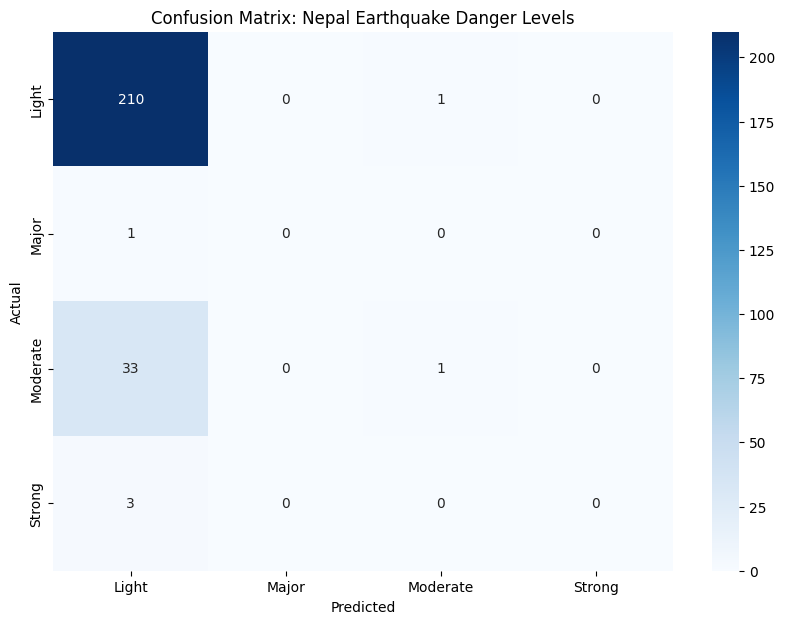

In [12]:
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Nepal Earthquake Danger Levels')
plt.show()

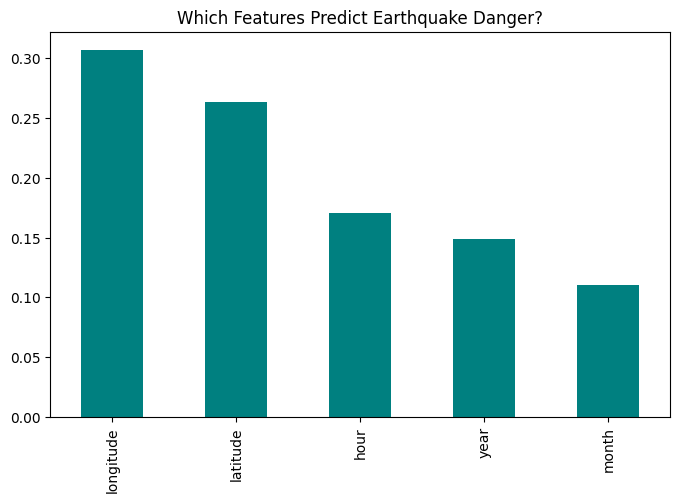

In [13]:
importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
importance.plot(kind='bar', color='teal')
plt.title('Which Features Predict Earthquake Danger?')
plt.show()

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

Overall Accuracy: 0.85


In [15]:
import joblib
model_filename = 'nepal_earthquake_model.joblib'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")
joblib.dump(le, 'label_encoder.joblib')
print("Label encoder saved to label_encoder.joblib")

Model saved to nepal_earthquake_model.joblib
Label encoder saved to label_encoder.joblib


In [16]:
# loaded_model = joblib.load('nepal_earthquake_model.joblib')
# loaded_le = joblib.load('label_encoder.joblib')

In [17]:
def predict_earthquake_danger(lat, lon, hour, month, year):
    input_data = pd.DataFrame([[lat, lon, hour, month, year]], 
                              columns=['latitude', 'longitude', 'hour', 'month', 'year'])
    
    prediction_numeric = model.predict(input_data)
    prediction_label = le.inverse_transform(prediction_numeric)[0]
    
    return prediction_label

test_prediction = predict_earthquake_danger(27.7, 85.3, 14, 4, 2025)
print(f"Predicted Danger Level for Kathmandu: {test_prediction}")

Predicted Danger Level for Kathmandu: Light
